<a href="https://colab.research.google.com/github/mjokeit/PINN_heat/blob/master/notebooks/1Dheat_systematic_weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# change directory

In [ ]:
import os
if os.getcwd() != '/content/drive/My Drive/Colab Notebooks/PINNs':
  os.chdir('/content/drive/My Drive/Colab Notebooks/PINNs')

# download data

In [ ]:
# !wget https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat

# install pyDOE

In [ ]:
!pip install -q pyDOE

# import plotting

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Oct  9 20:11:57 2017

@author: mraissi
"""

import numpy as np
import matplotlib as mpl
#mpl.use('pgf')

def figsize(scale, nplots = 1):
    fig_width_pt = 390.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = nplots*fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

# pgf_with_latex = {                      # setup matplotlib to use latex for output
#     "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
#     "text.usetex": True,                # use LaTeX to write all text
#     "font.family": "serif",
#     "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
#     "font.sans-serif": [],
#     "font.monospace": [],
#     "axes.labelsize": 10,               # LaTeX default is 10pt font.
#     "font.size": 10,
#     "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
#     "xtick.labelsize": 8,
#     "ytick.labelsize": 8,
#     "figure.figsize": figsize(1.0),     # default fig size of 0.9 textwidth
#     "pgf.preamble": [
#         r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
#         r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
#         ]
#     }
# mpl.rcParams.update(pgf_with_latex)

import matplotlib.pyplot as plt

# I make my own newfig and savefig functions
def newfig(width, nplots = 1):
    fig = plt.figure(figsize=figsize(width, nplots))
    ax = fig.add_subplot(111)
    return fig, ax

def savefig(filename, crop = True):
    if crop == True:
#        plt.savefig('{}.pgf'.format(filename), bbox_inches='tight', pad_inches=0)
        plt.savefig('{}.pdf'.format(filename), bbox_inches='tight', pad_inches=0)
        # plt.savefig('{}.eps'.format(filename), bbox_inches='tight', pad_inches=0)
    else:
#        plt.savefig('{}.pgf'.format(filename))
        plt.savefig('{}.pdf'.format(filename))
        # plt.savefig('{}.eps'.format(filename))

## Simple plot
#fig, ax  = newfig(1.0)
#
#def ema(y, a):
#    s = []
#    s.append(y[0])
#    for t in range(1, len(y)):
#        s.append(a * y[t] + (1-a) * s[t-1])
#    return np.array(s)
#    
#y = [0]*200
#y.extend([20]*(1000-len(y)))
#s = ema(y, 0.01)
#
#ax.plot(s)
#ax.set_xlabel('X Label')
#ax.set_ylabel('EMA')
#
#savefig('ema')

# PINN class

In [ ]:
"""
@author: Maziar Raissi
"""

import sys
from pathlib import Path

# sys.path.insert(0, '../Utilities')

# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
# import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
# from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

np.random.seed(1234)
tf.set_random_seed(1234)



class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x0, u0, tb, X_f, X_f_val, layers, lb, ub, min_max_f, X_star, u_star):

        X0 = np.concatenate((x0, 0 * x0), 1)  # (x0, 0)
        X_lb = np.concatenate((0 * tb + lb[0], tb), 1)  # (lb[0], tb)
        X_ub = np.concatenate((0 * tb + ub[0], tb), 1)  # (ub[0], tb)

        self.lb = lb
        self.ub = ub

        self.X_star = X_star
        self.u_star = u_star

        self.min_f = min_max_f[0]
        self.max_f = min_max_f[1]

        self.x0 = X0[:, 0:1]
        self.t0 = X0[:, 1:2]

        self.x_lb = X_lb[:, 0:1]
        self.t_lb = X_lb[:, 1:2]

        self.x_ub = X_ub[:, 0:1]
        self.t_ub = X_ub[:, 1:2]

        self.x_f = X_f[:, 0:1]
        self.t_f = X_f[:, 1:2]

        self.x_f_val = X_f_val[:, 0:1]
        self.t_f_val = X_f_val[:, 1:2]

        self.u0 = u0

        self.log_var_u0 = tf.Variable(1.0, dtype='float32')
        self.log_var_ub = tf.Variable(1.0, dtype='float32')
        self.log_var_f = tf.Variable(1.0, dtype='float32')

        # Initialize NNs
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)

        # tf Placeholders
        self.training = tf.placeholder(tf.bool)
        self.penalties = tf.placeholder(tf.float32, shape=(3))

        self.x0_tf = tf.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.t0_tf = tf.placeholder(tf.float32, shape=[None, self.t0.shape[1]])

        self.u0_tf = tf.placeholder(tf.float32, shape=[None, self.u0.shape[1]])

        self.x_lb_tf = tf.placeholder(tf.float32, shape=[None, self.x_lb.shape[1]])
        self.t_lb_tf = tf.placeholder(tf.float32, shape=[None, self.t_lb.shape[1]])

        self.x_ub_tf = tf.placeholder(tf.float32, shape=[None, self.x_ub.shape[1]])
        self.t_ub_tf = tf.placeholder(tf.float32, shape=[None, self.t_ub.shape[1]])

        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])

        self.x_f_tf_val = tf.placeholder(tf.float32, shape=[None, self.x_f_val.shape[1]])
        self.t_f_tf_val = tf.placeholder(tf.float32, shape=[None, self.t_f_val.shape[1]])

        self.X_star_tf = tf.placeholder(tf.float32, shape=[None, self.X_star.shape[1]])

        # tf Graphs
        self.u0_pred, self.u0_x_pred = self.net_u(self.x0_tf, self.t0_tf)
        self.u_lb_pred, self.u_x_lb_pred = self.net_u(self.x_lb_tf, self.t_lb_tf)
        self.u_ub_pred, self.u_x_ub_pred = self.net_u(self.x_ub_tf, self.t_ub_tf)
        self.f_pred = self.net_f(self.x_f_tf, self.t_f_tf)
        self.s_pred = self.net_s(self.x_f_tf, self.t_f_tf)
        self.f_pred_val = self.net_f(self.x_f_tf_val, self.t_f_tf_val)
        self.s_pred_val = self.net_s(self.x_f_tf_val, self.t_f_tf_val)
        self.u_pred, _ = self.net_u(self.X_star_tf[:, 0:1], self.X_star_tf[:, 1:2])

        self.delta_u0 = tf.reduce_mean(self.u0_pred - self.u0_tf)

        # relative scaling
        # sf = 1  # scale factor
        # self.scaled_u0_tf = 1 + 3*(self.u0_tf - tf.reduce_min(self.u0_tf)) / \
        #                       (tf.reduce_max(self.u0_tf) - tf.reduce_min(self.u0_tf))
        # self.scaled_u0_pred = 1 + 3*(self.u0_pred - tf.reduce_min(self.u0_tf)) / \
        #                       (tf.reduce_max(self.u0_tf) - tf.reduce_min(self.u0_tf))
        # self.scaled_u_x_lb_pred = self.u_x_lb_pred
        # self.scaled_u_x_ub_pred = self.u_x_ub_pred
        # self.scaled_f_pred = 1 + 3*(self.f_pred - self.min_f) / \
        #                      (self.max_f - self.min_f)
        # self.scaled_s_pred = 1 + 3*(self.s_pred - self.min_f) / \
        #                      (self.max_f - self.min_f)
        # self.scaled_f_pred_val = self.min_max_scale(self.f_pred_val, self.min_f, self.max_f)
        # self.scaled_s_pred_val = self.min_max_scale(self.s_pred_val, self.min_f, self.max_f)


        # scaling between [-sf, sf]
        # sf = 1  # scale factor
        # self.scaled_u0_tf = 2*sf * (self.u0_tf - tf.reduce_min(self.u0_tf)) / \
        #                       (tf.reduce_max(self.u0_tf) - tf.reduce_min(self.u0_tf)) - sf
        # self.scaled_u0_pred = 2*sf * (self.u0_pred - tf.reduce_min(self.u0_tf)) / \
        #                       (tf.reduce_max(self.u0_tf) - tf.reduce_min(self.u0_tf)) - sf
        # self.scaled_u_x_lb_pred = self.u_x_lb_pred
        # self.scaled_u_x_ub_pred = self.u_x_ub_pred
        # self.scaled_f_pred = 2*sf * (self.f_pred - self.min_f) / \
        #                      (self.max_f - self.min_f) - sf
        # self.scaled_s_pred = 2*sf * (self.s_pred - self.min_f) / \
        #                      (self.max_f - self.min_f) - sf
        # self.scaled_f_pred_val = self.min_max_scale(self.f_pred_val, self.min_f, self.max_f)
        # self.scaled_s_pred_val = self.min_max_scale(self.s_pred_val, self.min_f, self.max_f)

        # scaling by absolute maximum
        abs_max_f = tf.cast(tf.reduce_max(tf.abs(min_max_f)), 'float32')
        abs_max_u0 = tf.cast(tf.reduce_max(tf.abs(self.u0_tf)), 'float32')
        self.scaled_u0_tf = self.u0_tf / abs_max_u0
        self.scaled_u0_pred = self.u0_pred / abs_max_u0
        self.scaled_u_x_lb_pred = self.u_x_lb_pred
        self.scaled_u_x_ub_pred = self.u_x_ub_pred
        self.scaled_f_pred = self.f_pred / abs_max_f
        self.scaled_s_pred = self.s_pred / abs_max_f
        self.scaled_f_pred_val = self.f_pred_val / abs_max_f
        self.scaled_s_pred_val = self.s_pred_val / abs_max_f

        # Loss
        # self.loss_u0 = tf.reduce_mean(tf.square(self.scaled_u0_pred/self.scaled_u0_tf - 1))
        # self.loss_ub = tf.reduce_mean(tf.square(self.scaled_u_x_lb_pred)) +\
        #                tf.reduce_mean(tf.square(self.scaled_u_x_ub_pred))
        # self.loss_f = tf.reduce_mean(tf.square(self.scaled_f_pred/self.scaled_s_pred - 1))
        # self.val_loss_f = tf.reduce_mean(tf.square(self.scaled_f_pred_val - self.scaled_s_pred_val))


        self.loss_u0 = tf.reduce_mean(tf.square(self.scaled_u0_tf - self.scaled_u0_pred))
        self.loss_ub = tf.reduce_mean(tf.square(self.scaled_u_x_lb_pred)) +\
                       tf.reduce_mean(tf.square(self.scaled_u_x_ub_pred))
        self.loss_f = tf.reduce_mean(tf.square(self.scaled_f_pred - self.scaled_s_pred))
        self.val_loss_f = tf.reduce_mean(tf.square(self.scaled_f_pred_val - self.scaled_s_pred_val))

        # self.loss_u0 = tf.reduce_mean(tf.square(self.u0_tf - self.u0_pred)) # 1e7 good results
        # self.loss_ub = (tf.reduce_mean(tf.square(self.u_x_lb_pred)) +
        #                 tf.reduce_mean(tf.square(self.u_x_ub_pred)))
        # self.loss_f = tf.reduce_mean(tf.square(self.f_pred - self.s_pred))
        # self.val_loss_f = tf.reduce_mean(tf.square(self.f_pred_val - self.s_pred_val))

        # self.loss_u0 = tf.sqrt(tf.reduce_sum(tf.square(self.u0_tf - self.u0_pred)))
        # self.loss_ub = tf.sqrt(tf.reduce_sum(tf.square(self.u_x_lb_pred)) + tf.reduce_sum(tf.square(self.u_x_ub_pred)))
        # self.loss_f = tf.sqrt(tf.reduce_sum(tf.square(self.f_pred - self.s_pred)))
        # self.val_loss_f = tf.reduce_mean(tf.square(self.f_pred_val - self.s_pred_val))

        self.loss = self.penalties[0] * self.loss_u0 + self.penalties[1] * self.loss_ub + self.penalties[2] * self.loss_f
        # self.loss = 1e0 * (self.loss_u0 + self.loss_ub + self.loss_f) # +1 one to get a relative error in the scipy optimizer NOT WORKING
        # self.loss = 1e0 * (tf.log(self.loss_u0 + 1) + tf.log(self.loss_ub + 1) + tf.log(self.loss_f + 1)) # +1 one to get a relative error in the scipy optimizer NOT WORKING
        # self.loss = self.adaptive_loss()



            # Optimizers
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss,
                                                                method='L-BFGS-B',
                                                                options={'maxiter': 50000,
                                                                         'maxfun': 50000,
                                                                         'maxcor': 50,
                                                                         'maxls': 50,
                                                                         'ftol': 1e0 * np.finfo(float).eps, # ftol
                                                                         # 'gtol': 1e-12
                                                                         })

        self.optimizer_Adam = tf.train.AdamOptimizer(0.001) # more data, higher learning rate

        # update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        # with tf.control_dependencies(update_ops):
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)

        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        init = tf.global_variables_initializer()
        self.sess.run(init)

        self.train_history = []
        self.error_u_history = []

    # promising weighted loss approach should be easy to implement
    # https://arxiv.org/pdf/1705.07115.pdf
    def adaptive_loss(self):
        pre_u0 = tf.exp(-self.log_var_u0)
        pre_ub = tf.exp(-self.log_var_ub)
        pre_f = tf.exp(-self.log_var_f)
        loss = pre_u0*self.loss_u0 + pre_ub*self.loss_ub + pre_f*self.loss_f + \
               self.log_var_u0 + self.log_var_ub + self.log_var_f
        return loss


    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size): # glorot normal initialization
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    # def xavier_init(self, size): # glorot uniform initialization
    #     in_dim = size[0]
    #     out_dim = size[1]
    #     limit = np.sqrt(6 / (in_dim + out_dim))
    #     return tf.Variable(tf.random_uniform([in_dim, out_dim], -limit, limit), dtype=tf.float32)

    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1

        # H = (X - self.lb) / (self.ub - self.lb) # suitable for swish acitvation
        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        # H = (X - tf.reduce_mean(X)) / tf.sqrt(tf.square(tf.math.reduce_std(X)) + 1e-3)
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            # H = tf.tanh(tf.add(tf.matmul(H, W), b))
            H = tf.sin(tf.add(tf.matmul(H, W), b))
            # H = tf.asinh(tf.add(tf.matmul(H, W), b))
            # H = tf.nn.swish(tf.add(tf.matmul(H, W), b)) # does not work well for continuous PINN
            # H = tf.contrib.layers.batch_norm(H, center=True, scale=True, is_training=self.training)
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_u(self, x, t):
        X = tf.concat([x, t], 1)
        u = self.neural_net(X, self.weights, self.biases)
        u_x = tf.gradients(u, x)[0]
        return u, u_x

    def net_f(self, x, t):
        # computations for the lhs
        u, u_x = self.net_u(x, t)
        u_t = tf.gradients(u, t)[0]
        u_xx = tf.gradients(u_x, x)[0]

        u_max = 800
        sigma = 0.02
        us = u_max

        # k = 6.856
        k = (1.29 * 10 ** -2 * u*us + 6.856)
        k_u = 1.29 * 10 ** -2 * us
        k_x = k_u * u_x

        # c = 5.849 * 10 ** 2
        c = (4.55 * 10 ** -4 * (u*us) ** 2 - 5.78 * 10 ** -3 * u*us + 5.849 * 10 ** 2)

        # lhs = c/k * u_t - u_xx
        lhs = c * u_t - k_x * u_x - k * u_xx

        f = lhs
        return f

    def net_s(self, x, t):
        t_max = 0.5
        sigma = 0.02
        u_max = 800

        us = u_max

        # computations for the rhs
        # p = t + 0.1
        p = 0.25 * tf.cos(2 * np.pi * t / t_max) + 0.5
        p_t = tf.gradients(p, t)[0]

        u_sol = u_max * tf.exp(-(x - p) ** 2 / (2 * sigma ** 2))

        # k_sol = 6.856
        k_sol = 1.29 * 10 ** -2 * u_sol + 6.856
        k_u_sol = 1.29 * 10 ** -2

         # c_sol = 5.849 * 10 ** 2
        c_sol = 4.55 * 10 ** -4 * u_sol ** 2 - 5.78 * 10 ** -3 * u_sol + 5.849 * 10 ** 2

        rhs = 1/us * 1/sigma**2 * k_sol * u_sol + 1/us * u_sol * (x - p) * 1/sigma**2 * (
                c_sol * p_t - (x - p) * 1/sigma**2 * (k_sol + u_sol * k_u_sol))
        # rhs = u_dash/sigma**2 + u_dash * (x - p) / sigma**2 * (c_sol/k_sol - (x - p)/sigma**2)

        s = rhs

        return s

    def callback(self, loss, loss_u0, loss_ub, loss_f, val_loss_f, f_pred, scaled_f_pred, s_pred, scaled_s_pred, u_pred):
        error_u = np.linalg.norm(self.u_star - u_pred, 2) / np.linalg.norm(self.u_star, 2)
        print('f_pred: %.3e, scaled_f_pred: %.3e, s_pred: %.3e, scaled_s_pred: %.3e,' %
              (np.max(f_pred), np.max(scaled_f_pred),
               np.max(s_pred), np.max(scaled_s_pred)))
        print('Loss: %.3e, Loss u0: %.3e, Loss ub: %.3e, Loss f: %.3e, Val. Loss f: %.3e' % (loss, loss_u0, loss_ub, loss_f, val_loss_f))
        self.train_history.append([loss, loss_u0, loss_ub, loss_f, val_loss_f])
        print('Error u: %e' % (error_u))
        self.error_u_history.append(error_u)

    def train(self, nIter):

        tf_dict = {self.x0_tf: self.x0, self.t0_tf: self.t0,
                   self.u0_tf: self.u0,
                   self.x_lb_tf: self.x_lb, self.t_lb_tf: self.t_lb,
                   self.x_ub_tf: self.x_ub, self.t_ub_tf: self.t_ub,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f,
                   self.x_f_tf_val: self.x_f_val, self.t_f_tf_val: self.t_f_val,
                   self.X_star_tf: self.X_star,
                   self.penalties: np.array([1.,1.,1.]),
                   self.training: True}

        # for it in range(10):
        #     self.sess.run(self.train_op_Adam, tf_dict)
        #
        # loss_u0, loss_ub, loss_f = self.sess.run((self.loss_u0, self.loss_ub, self.loss_f), tf_dict)
        # penalties = np.reciprocal(np.array([loss_u0, loss_ub, loss_f]))
        # tf_dict[self.penalties] = penalties

        batch_size = 2000

        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            # for batch in range(int(N_f/batch_size)):
            #     batch_idx = np.random.choice(self.x_f.shape[0], batch_size, replace=False)
            #     tf_dict[self.x_f_tf] = self.x_f[batch_idx]
            #     tf_dict[self.t_f_tf] = self.t_f[batch_idx]
            #     self.sess.run(self.train_op_Adam, tf_dict)
            #     # print(f'Batch no. {batch} finished')

            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value, loss_u0, loss_ub, loss_f, val_loss_f, u_pred = self.sess.run((self.loss, self.loss_u0, self.loss_ub, self.loss_f, self.val_loss_f, self.u_pred), tf_dict)
                error_u = np.linalg.norm(self.u_star - u_pred, 2) / np.linalg.norm(self.u_star, 2)
                print('It: %d, Loss: %.3e, Loss u0: %.3e, Loss ub: %.3e, Loss f: %.3e, Val. Loss f: %.3e, Time: %.2f' %
                      (it, loss_value, loss_u0, loss_ub, loss_f, val_loss_f, elapsed))
                print('Error u: %e' % (error_u))
                self.error_u_history.extend(error_u for i in range(10))
                self.train_history.extend([loss_value, loss_u0, loss_ub, loss_f, val_loss_f] for i in range(10))
                start_time = time.time()
                # if it == 0:
                #     penalties = np.reciprocal(np.array([loss_u0, loss_ub, loss_f]))
                #     # penalties = np.array([0., penalties[1], penalties[2]])
                #     tf_dict[self.penalties] = penalties

        self.optimizer.minimize(self.sess,
                                feed_dict=tf_dict,
                                fetches=[self.loss, self.loss_u0, self.loss_ub,
                                         self.loss_f, self.val_loss_f,
                                         self.f_pred, self.scaled_f_pred,
                                         self.s_pred, self.scaled_s_pred,
                                         self.u_pred],
                                loss_callback=self.callback)


        return self.train_history, self.error_u_history

    def predict(self, X_star):

        # delta_u0, last_bias = self.sess.run((self.delta_u0, self.biases[-1]), {self.x0_tf: self.x0, self.t0_tf: self.t0, self.u0_tf: self.u0})
        # print('b[-1] before: ', last_bias)
        # print('delta u0 before: ', delta_u0)
        # last_bias = last_bias - delta_u0
        # delta_u0, last_bias = self.sess.run((self.delta_u0, self.biases[-1]),
        #                                     {self.x0_tf: self.x0, self.t0_tf: self.t0,
        #                                      self.u0_tf: self.u0, self.biases[-1]: last_bias})
        # print('b[-1] after: ', last_bias)
        # print('delta u0 after: ', delta_u0)

        tf_dict = {self.x0_tf: X_star[:, 0:1], self.t0_tf: X_star[:, 1:2], self.training: False}

        u_star, u_x_star = self.sess.run((self.u0_pred, self.u0_x_pred), tf_dict)

        tf_dict = {self.x_f_tf: X_star[:, 0:1], self.t_f_tf: X_star[:, 1:2], self.training: False}

        f_star, s_star = self.sess.run((self.f_pred, self.s_pred), tf_dict)

        W, b = self.sess.run((self.weights, self.biases), None)

        num_layers = len(W)
        max_W, max_b = [], []
        for i in range(0, num_layers):
            max_W.append(np.amax(np.abs(W[i])))
            max_b.append(np.amax(np.abs(b[i])))

        # max_W = np.amax(W)
        # max_b = np.amax(b)
        max_W = max(max_W)
        max_b = max(max_b)

        return u_star, u_x_star, f_star, s_star, max_W, max_b

    def min_max_scale(self, X, X_min, X_max):
        X_scaled = 2 * (X - X_min) / (X_max - X_min) - 1
        return X_scaled


# main loop

In [ ]:
def main_loop(loop_count): 

    noise = 0.0

    N0 = 100
    N_b = 50
    N_f = 20000
    N_f_val = 2000
    layers = [2, 20, 20, 20, 1] # change layer structure

    print(os.getcwd())

    data = scipy.io.loadmat('../../../data/heat1D_nondim.mat')

    t = data['t'].flatten()[:, None]
    x = data['x'].flatten()[:, None]
    Exact = data['usol_nondim'].T
    Exact_flux = data['fluxsol_nondim'].T
    min_max_f = data['min_max_f_nondim']

    X, T = np.meshgrid(x, t)

    X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
    u_star = Exact.flatten()[:, None]
    flux_star = Exact_flux.flatten()[:, None]

    # Domain bounds
    lb = X_star.min(0)
    ub = X_star.max(0)

    ###########################

    idx_x = np.random.choice(x.shape[0], N0, replace=False)
    x0 = x[idx_x, :]
    u0 = Exact.T[idx_x, 0:1]

    idx_t = np.random.choice(t.shape[0], N_b, replace=False)
    tb = t[idx_t, :]

    X_f = lb + (ub - lb) * lhs(2, N_f)
    X_f_val = lb + (ub - lb) * lhs(2, N_f_val)

    model = PhysicsInformedNN(x0, u0, tb, X_f, X_f_val, layers, lb, ub, min_max_f, X_star, u_star)

    start_time = time.time()
    # model.train(10000)
    train_history, error_u_history = model.train(10000)
    iterations = len(train_history)
    print('Iterations: %d' % (iterations))
    elapsed = time.time() - start_time
    print('Training time: %.4f' % (elapsed))

    u_pred, u_x_pred, f_pred, s_pred, max_W, max_b = model.predict(X_star)
    print(f'max_W: {max_W}, max_b: {max_b}')

    # computing heat flux
    u_max = 800
    us = u_max
    k = 1.29 * 10 ** -2 * u_pred + 6.856
    # k = 6.856
    flux_pred = -k * u_x_pred

    error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
    print('Error u: %e' % (error_u))

    error_flux = np.linalg.norm(flux_star - flux_pred, 2) / np.linalg.norm(flux_star, 2)
    print('Error flux: %e' % (error_flux))

    U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
    Error = np.abs(Exact - U_pred)

    Flux_pred = griddata(X_star, flux_pred.flatten(), (X, T), method='cubic')
    Error_flux = np.abs(Exact_flux - Flux_pred)

    F_pred = griddata(X_star, f_pred.flatten(), (X, T), method='cubic')

    ######################################################################
    ############################# Plotting ###############################
    ######################################################################

    fig0, ax0 = newfig(1.0, 2)
    ax0.axis('off')

    ax0 = plt.subplot(2,1,1)
    loss, loss_u0, loss_ub, loss_f, val_loss_f = ax0.plot(train_history)
    ax0.set_yscale('log')
    plt.legend([loss, loss_u0, loss_ub, loss_f, val_loss_f],
               ['loss', 'loss u0', 'loss ub', 'loss f', 'val loss f'])

    ax0 = plt.subplot(2, 1, 2)
    error_u_plot = ax0.plot(error_u_history, label='error u')
    ax0.set_yscale('log')
    plt.legend()
    savefig(f'1Dheat_Neumann_nondim_losses_error_{loop_count}')

    X0 = np.concatenate((x0, 0 * x0), 1)  # (x0, 0)
    X_lb = np.concatenate((0 * tb + lb[0], tb), 1)  # (lb[0], tb)
    X_ub = np.concatenate((0 * tb + ub[0], tb), 1)  # (ub[0], tb)
    X_u_train = np.vstack([X0, X_lb, X_ub])

    fig, ax = newfig(1.0, 3)
    ax.axis('off')

    ####### Row 0: u(t,x) ##################
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1 - 0.06, bottom=1 - 1 / 4, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow',
                  extent=[t.min(), t.max(), x.min(), x.max()],
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)

    # plot data points used for training as 'x'
    ax.plot(X_u_train[:, 1], X_u_train[:, 0], 'kx', label='data (%d points)' % (X_u_train.shape[0]), markersize=4,
            clip_on=False)

    # white lines on upper plot
    line = np.linspace(x.min(), x.max(), 2)[:, None]
    ax.plot(t[50] * np.ones((2, 1)), line, 'w-', linewidth=1)
    # ax.plot(t[25] * np.ones((2, 1)), line, 'w-', linewidth=1)
    ax.plot(t[100] * np.ones((2, 1)), line, 'w-', linewidth=1)
    ax.plot(t[150] * np.ones((2, 1)), line, 'w-', linewidth=1)

    # labels and legend for upper plot
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc='best')
    ax.set_title('$u(t,x)$', fontsize=10)

    ####### Row 1: phi(t,x) ##################
    gs1 = gridspec.GridSpec(1, 2)
    gs1.update(top=1 - 1 / 4 - 0.06, bottom=1 - 1 / 2, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs1[:, :])

    h = ax.imshow(Flux_pred.T, interpolation='nearest', cmap='rainbow',
                  extent=[t.min(), t.max(), x.min(), x.max()],
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)

    # plot data points used for training as 'x'
    ax.plot(X_u_train[:, 1], X_u_train[:, 0], 'kx', label='data (%d points)' % (X_u_train.shape[0]), markersize=4,
            clip_on=False)

    # white lines on upper plot
    line = np.linspace(x.min(), x.max(), 2)[:, None]
    ax.plot(t[50] * np.ones((2, 1)), line, 'w-', linewidth=1)
    # ax.plot(t[25] * np.ones((2, 1)), line, 'w-', linewidth=1)
    ax.plot(t[100] * np.ones((2, 1)), line, 'w-', linewidth=1)
    ax.plot(t[150] * np.ones((2, 1)), line, 'w-', linewidth=1)

    # labels and legend for upper plot
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc='best')
    ax.set_title('$\phi(t,x)$', fontsize=10)

    ####### Row 2: u(t,x) slices ##################
    gs2 = gridspec.GridSpec(1, 3)
    gs2.update(top=1 - 1 / 2, bottom=1 - 3 / 4, left=0.1, right=0.9, wspace=0.5)

    ax = plt.subplot(gs2[0, 0])
    ax.plot(x, Exact[50, :], 'b-', linewidth=2, label='Exact')
    ax.plot(x, U_pred[50, :], 'r--', linewidth=2, label='Prediction')
    # ax.plot(x, Exact[25, :], 'b-', linewidth=2, label='Exact')
    # ax.plot(x, U_pred[25, :], 'r--', linewidth=2, label='Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.set_title('$t = 0.125$', fontsize=10)
    ax.axis('square')
    ax.set_xlim([lb[0] - 0.1, ub[0] + 0.1])
    ax.set_ylim([Exact.min() - 0.1, Exact.max() + 0.1])

    ax = plt.subplot(gs2[0, 1])
    ax.plot(x, Exact[100, :], 'b-', linewidth=2, label='Exact')
    ax.plot(x, U_pred[100, :], 'r--', linewidth=2, label='Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.axis('square')
    ax.set_xlim([lb[0] - 0.1, ub[0] + 0.1])
    ax.set_ylim([Exact.min() - 0.1, Exact.max() + 0.1])
    ax.set_title('$t = 0.25$', fontsize=10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs2[0, 2])
    ax.plot(x, Exact[150, :], 'b-', linewidth=2, label='Exact')
    ax.plot(x, U_pred[150, :], 'r--', linewidth=2, label='Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.axis('square')
    ax.set_xlim([lb[0] - 0.1, ub[0] + 0.1])
    ax.set_ylim([Exact.min() - 0.1, Exact.max() + 0.1])
    ax.set_title('$t = 0.375$', fontsize=10)

    ####### Row 3: phi(t,x) slices ##################
    gs3 = gridspec.GridSpec(1, 3)
    gs3.update(top=1 - 3 / 4, bottom=0, left=0.1, right=0.9, wspace=0.5)

    ax = plt.subplot(gs3[0, 0])
    ax.plot(x, Exact_flux[50, :], 'b-', linewidth=2, label='Exact')
    ax.plot(x, Flux_pred[50, :], 'r--', linewidth=2, label='Prediction')
    # ax.plot(x, Exact[25, :], 'b-', linewidth=2, label='Exact')
    # ax.plot(x, U_pred[25, :], 'r--', linewidth=2, label='Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\phi(t,x)$')
    ax.set_title('$t = 0.125$', fontsize=10)
    # ax.axis('square')
    ax.set_xlim([lb[0] - 0.1, ub[0] + 0.1])
    ax.set_ylim([Exact_flux.min() * (1 + 0.1), Exact_flux.max() * (1 + 0.1)])

    ax = plt.subplot(gs3[0, 1])
    ax.plot(x, Exact_flux[100, :], 'b-', linewidth=2, label='Exact')
    ax.plot(x, Flux_pred[100, :], 'r--', linewidth=2, label='Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\phi(t,x)$')
    # ax.axis('square')
    ax.set_xlim([lb[0] - 0.1, ub[0] + 0.1])
    ax.set_ylim([Exact_flux.min() * (1 + 0.1), Exact_flux.max() * (1 + 0.1)])
    ax.set_title('$t = 0.25$', fontsize=10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs3[0, 2])
    ax.plot(x, Exact_flux[150, :], 'b-', linewidth=2, label='Exact')
    ax.plot(x, Flux_pred[150, :], 'r--', linewidth=2, label='Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\phi(t,x)$')
    # ax.axis('square')
    ax.set_xlim([lb[0] - 0.1, ub[0] + 0.1])
    ax.set_ylim([Exact_flux.min() * (1 + 0.1), Exact_flux.max() * (1 + 0.1)])
    ax.set_title('$t = 0.375$', fontsize=10)

    savefig(f'1Dheat_Neumann_nondim_{loop_count}')

    return iterations, elapsed, error_u, error_flux 


# run loop



Streaming output truncated to the last 5000 lines.
f_pred: 7.691e+04, scaled_f_pred: 1.009e+00, s_pred: 7.694e+04, scaled_s_pred: 1.009e+00,
Loss: 3.227e-06, Loss u0: 2.172e-07, Loss ub: 1.077e-07, Loss f: 2.902e-06, Val. Loss f: 3.136e-06
Error u: 3.380225e-02
f_pred: 7.691e+04, scaled_f_pred: 1.009e+00, s_pred: 7.694e+04, scaled_s_pred: 1.009e+00,
Loss: 3.227e-06, Loss u0: 2.174e-07, Loss ub: 1.072e-07, Loss f: 2.902e-06, Val. Loss f: 3.136e-06
Error u: 3.383283e-02
f_pred: 7.692e+04, scaled_f_pred: 1.009e+00, s_pred: 7.694e+04, scaled_s_pred: 1.009e+00,
Loss: 3.226e-06, Loss u0: 2.176e-07, Loss ub: 1.067e-07, Loss f: 2.902e-06, Val. Loss f: 3.135e-06
Error u: 3.387522e-02
f_pred: 7.692e+04, scaled_f_pred: 1.009e+00, s_pred: 7.694e+04, scaled_s_pred: 1.009e+00,
Loss: 3.225e-06, Loss u0: 2.183e-07, Loss ub: 1.056e-07, Loss f: 2.901e-06, Val. Loss f: 3.133e-06
Error u: 3.395122e-02
f_pred: 7.692e+04, scaled_f_pred: 1.009e+00, s_pred: 7.694e+04, scaled_s_pred: 1.009e+00,
Loss: 3.225e-06

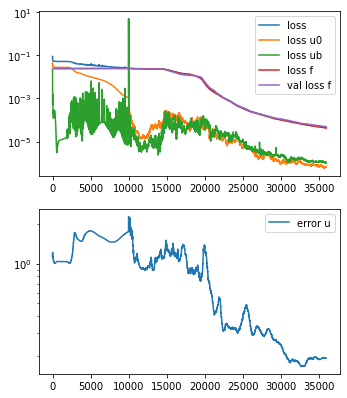

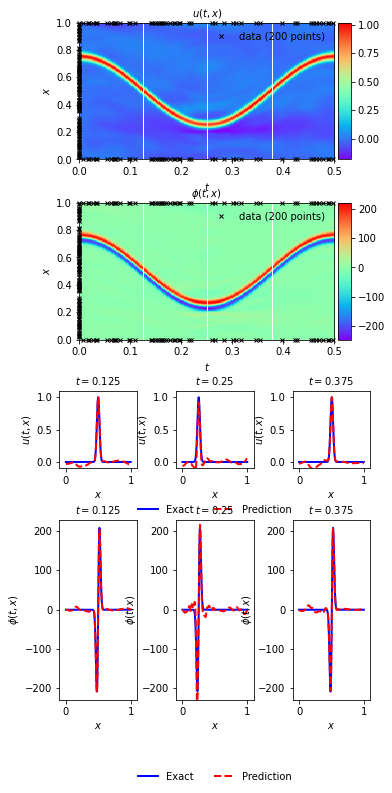

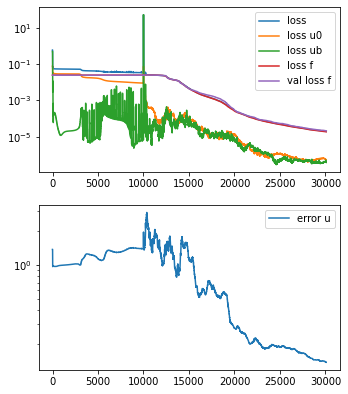

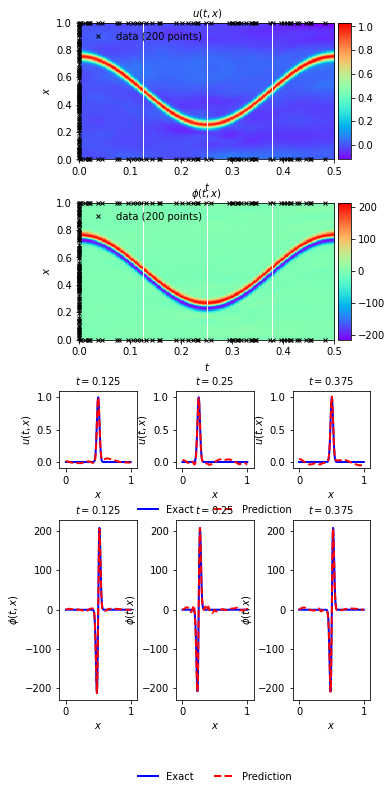

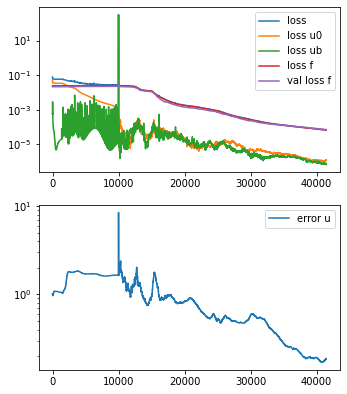

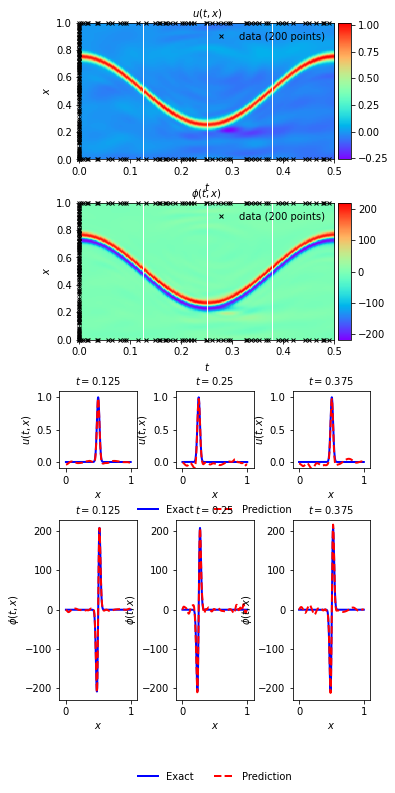

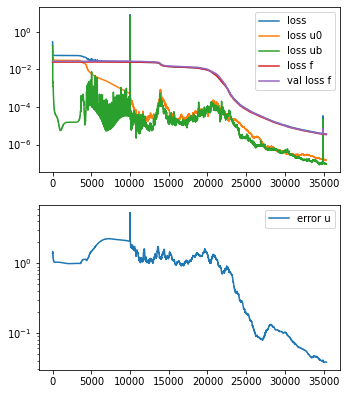

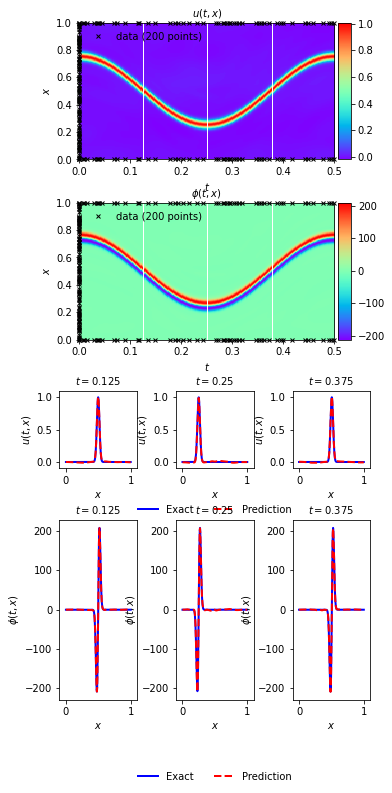

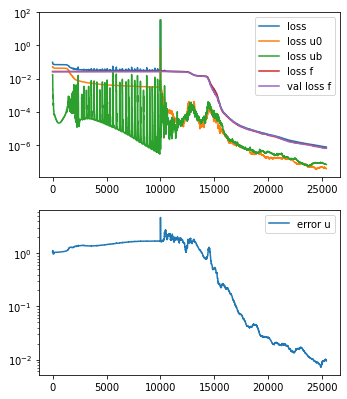

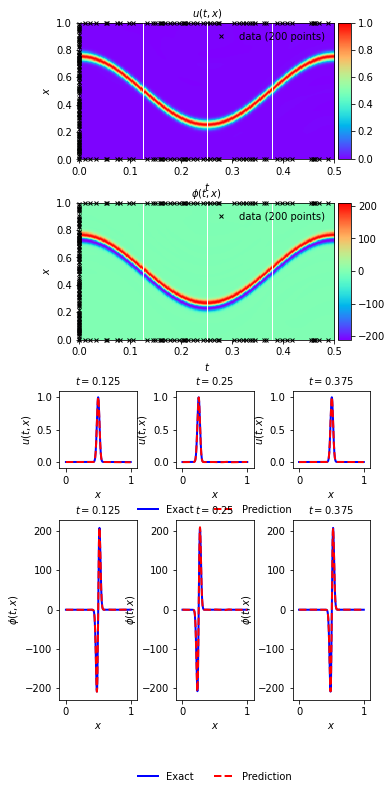

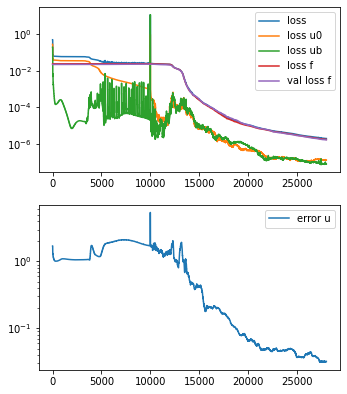

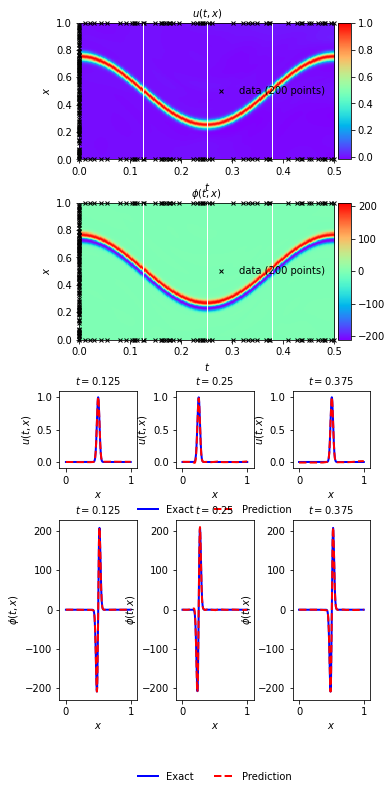

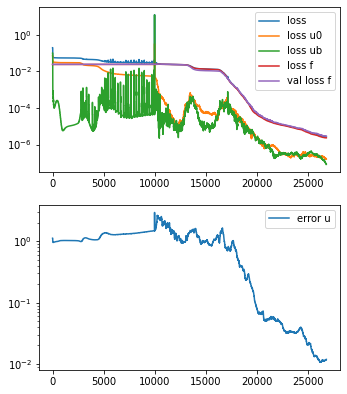

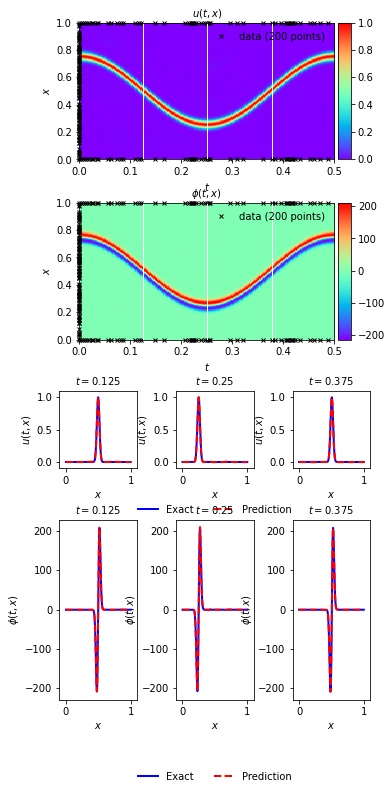

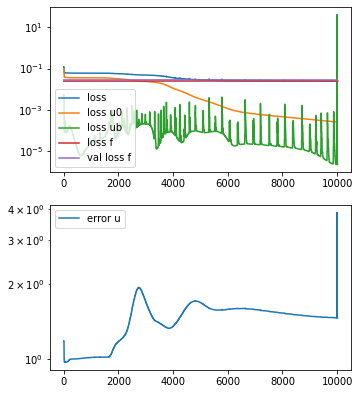

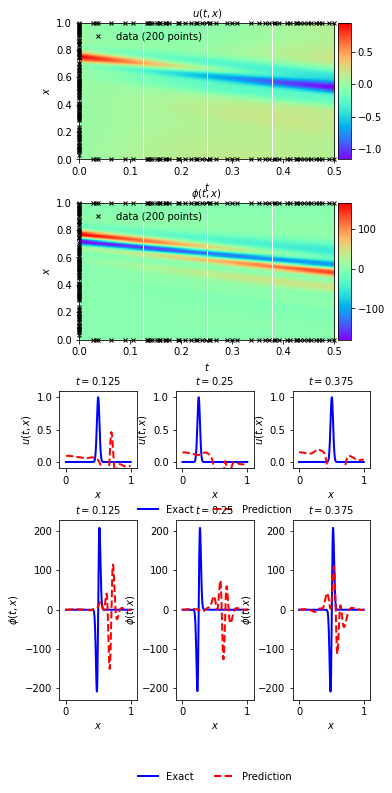

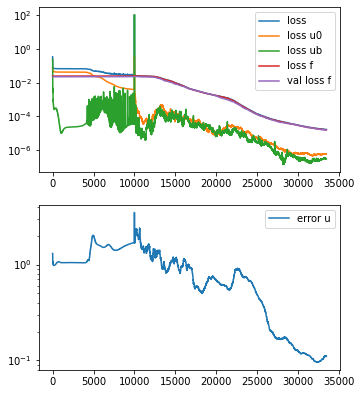

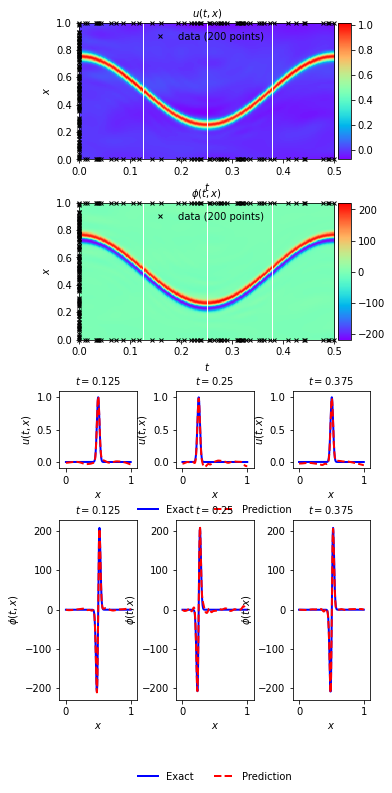

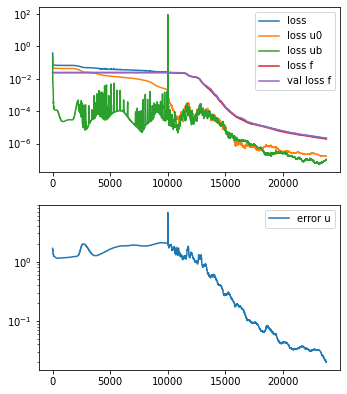

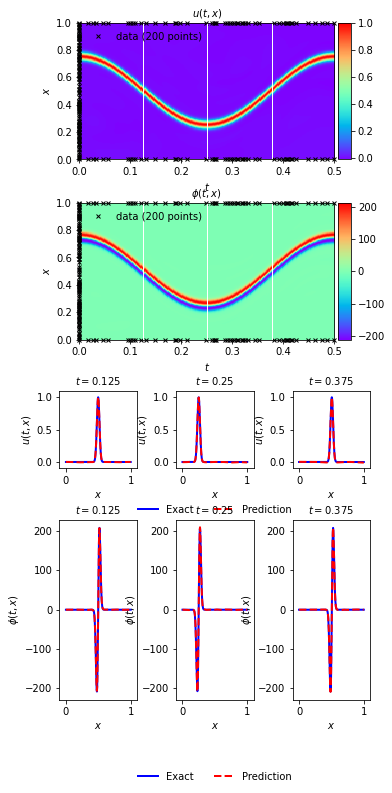

In [ ]:
loss_scaling = 'abs' # 'none' 'abs' 'min_max' 'adpative' 'auto0'
optimizer = 'Adam+L-BFGS' # 'Adam' 'L-BFGS'
iter = 10000 # 0, 20000, 30000
weight_init = 'normal' # 'uniform' 
activation =  'sin' # 'tanh'
loop = 10

folder_string = f'{loss_scaling}_{optimizer}_{iter}_{weight_init}_{activation}'

if os.getcwd() != '/content/drive/My Drive/Colab Notebooks/PINNs':
  os.chdir('/content/drive/My Drive/Colab Notebooks/PINNs')

if not os.path.exists('study/weights/' + folder_string):
  os.mkdir('study/weights/' + folder_string)

os.chdir('study/weights/' + folder_string)

table = np.zeros((loop, 4))

for loop_count in range(loop):
  table[loop_count] = main_loop(loop_count)
  np.savetxt('table.csv', table, delimiter=' & ', fmt='$%.2e$', newline=' \\\\\n')